In [1]:
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from skimage import io, transform
from torchvision import transforms, utils
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import torch.optim as optim
import time
import scipy
from sklearn.decomposition import PCA

In [2]:
def get_graphs(min_instance_count = 180, sim_filter=True, sim_thres=0.8, epochs = range(18), figsize = (18,12), only_combined = False):
    commons = (val_data.groupby(['label']).count()>min_instance_count)
    common_labels = commons[commons['img']==True].index
    print()
    print('common labels size is ' + str(len(common_labels)))

    for i in epochs:
        word_embs = word_embs_list[i]
        img_embs = img_embs_list[i]
        val_data['word_emb'] = word_embs
        val_data['img_emb'] = img_embs
        sim = (val_data['word_emb'] * val_data['img_emb'])
        sim = pd.DataFrame.from_items(zip(sim.index, sim.values)).T
        sim = np.sum(sim, axis = 1)

        pca = PCA(n_components=2) #2-dimensional PCA
        data = pd.concat([val_data['word_emb'], val_data['img_emb']])
        data = pd.DataFrame.from_items(zip(data.index, data.values)).T
        transformed = pd.DataFrame(pca.fit_transform(data))

        #sentence pca
        sentence_pca = PCA(n_components=2) #2-dimensional PCA
        sen_data = val_data['word_emb']
        sen_data = pd.DataFrame.from_items(zip(sen_data.index, sen_data.values)).T
        sentence_pca.fit(sen_data)
        sen_transformed = pd.DataFrame(sentence_pca.transform(data))

        #image pca
        img_pca = PCA(n_components=2) #2-dimensional PCA
        img_data = val_data['img_emb']
        img_data = pd.DataFrame.from_items(zip(img_data.index, img_data.values)).T
        img_pca.fit(img_data)
        img_transformed = pd.DataFrame(img_pca.transform(data))

        transformed = transformed.rename(index=str, columns={0: "combined_first", 1: "combined_second"})    
        sen_transformed = sen_transformed.rename(index=str, columns={0: "sen_first", 1: "sen_second"})    
        img_transformed = img_transformed.rename(index=str, columns={0: "img_first", 1: "img_second"})    

        all_transformations = pd.concat([transformed,sen_transformed,img_transformed], axis=1)
        all_transformations['type'] = [''] * 2 * len(gt_val_ids)
        all_transformations.iloc[:len(gt_val_ids)]['type'] = 'word embedding'
        all_transformations.iloc[len(gt_val_ids):]['type'] = 'image embedding'
        all_transformations['label'] = list(val_data['label'])*2
        all_transformations['cos_sim'] = list(sim) * 2
        print()
        print('at epoch: ' + str(i+1))
        print('combined pca explained_variance_ratio_: ' + str(pca.explained_variance_ratio_))
        print('text pca explained_variance_ratio_: \t' + str(sentence_pca.explained_variance_ratio_))
        print('image pca explained_variance_ratio_: \t' + str(img_pca.explained_variance_ratio_))

        data = all_transformations[all_transformations['label'].isin(common_labels)]
        if sim_filter:
            data = data[data['cos_sim'] >sim_thres]     
        # df is shuffled so that word embeddings don't stand behind of image embeddings because of the order
        data = data.sample(frac=1, replace=False, random_state=1)
        sns.set(rc={'figure.figsize':figsize})
        
        '''
        #show 3 graphs side by side
        fig, axs = plt.subplots(ncols=3)
        ax = sns.scatterplot(x='combined_first', y='combined_second', style='type', hue='label', data = data, ax=axs[0]).set_title('PCA-Combined Plot')
        bx = sns.scatterplot(x='sen_first', y='sen_second', style='type', hue='label', data = data,ax=axs[1]).set_title('PCA-Text Plot')
        cx = sns.scatterplot(x='img_first', y='img_second', style='type', hue='label', data = data,ax=axs[2]).set_title('PCA-Image Plot')
        plt.show()
        '''
        hue_order = ['sky-blue', 'man', 'grass', 'group-of-persons', 'ground']
        ax = sns.scatterplot(x='combined_first', y='combined_second', style='type', hue='label',hue_order = list(common_labels),
                             palette = 'bright', data = data).set_title('PCA-Combined Plot')
        plt.show()

        if not only_combined:
            bx = sns.scatterplot(x='sen_first', y='sen_second', style='type', hue='label', data = data).set_title('PCA-Text Plot')
            plt.show()
            cx = sns.scatterplot(x='img_first', y='img_second', style='type', hue='label', data = data).set_title('PCA-Image Plot')
            plt.show()
            

In [3]:
def get_graphs_with_final_model(min_instance_count = 180, sim_filter=True, sim_thres=0.8, epochs = range(18), figsize = (18,12)):
    commons = (val_data.groupby(['label']).count()>min_instance_count)
    common_labels = commons[commons['img']==True].index
    print(common_labels)
    print()
    print('common labels size is ' + str(len(common_labels)))
    
    last_epoch = max(epochs)
    word_embs = word_embs_list[last_epoch]
    img_embs = img_embs_list[last_epoch]
    val_data['word_emb'] = word_embs
    val_data['img_emb'] = img_embs
    pca = PCA(n_components=3) #2-dimensional PCA
    data = pd.concat([val_data['word_emb'], val_data['img_emb']])
    data = pd.DataFrame.from_items(zip(data.index, data.values)).T
    pca.fit(data)
    print('combined pca explained_variance_ratio_: ' + str(pca.explained_variance_ratio_))

    for i in epochs:
        word_embs = word_embs_list[i]
        img_embs = img_embs_list[i]
        val_data['word_emb'] = word_embs
        val_data['img_emb'] = img_embs
        sim = (val_data['word_emb'] * val_data['img_emb'])
        sim = pd.DataFrame.from_items(zip(sim.index, sim.values)).T
        sim = np.sum(sim, axis = 1)


        data = pd.concat([val_data['word_emb'], val_data['img_emb']])
        data = pd.DataFrame.from_items(zip(data.index, data.values)).T
        transformed = pd.DataFrame(pca.transform(data))

    
        transformed = transformed.rename(index=str, columns={0: "first axis", 1: "second axis"})    
        

        all_transformations = pd.concat([transformed], axis=1)
        all_transformations['type'] = [''] * 2 * len(gt_val_ids)
        all_transformations.iloc[:len(gt_val_ids)]['type'] = 'word embedding'
        all_transformations.iloc[len(gt_val_ids):]['type'] = 'image embedding'
        all_transformations['label'] = list(val_data['label'])*2
        all_transformations['cos_sim'] = list(sim) * 2
        print()
        print('at iter: ' + str((i+1)*2000))
        print('avg sim: ' + str(sim.mean()))
        print('std sim: ' + str(sim.std()))
        
        data = all_transformations[all_transformations['label'].isin(common_labels)]
        if sim_filter:
            data = data[data['cos_sim'] >sim_thres]     
        # df is shuffled so that word embeddings don't stand behind of image embeddings because of the order
        data = data.sample(frac=1, replace=False, random_state=1)
        sns.set(rc={'figure.figsize':figsize})
        hue_order = ['sky-blue', 'man', 'grass', 'group-of-persons', 'ground']
        ax = sns.scatterplot(x='first axis', y='second axis', style='type', hue='label', hue_order = hue_order,
                             palette = 'bright', data = data).set_title('PCA Projection of Selected Classes')
        plt.show()



In [5]:
def get_poster_graphs_with_final_model(min_instance_count = 180, sim_filter=True, sim_thres=0.8, epochs = range(18), figsize = (18,12)):
    commons = (val_data.groupby(['label']).count()>min_instance_count)
    common_labels = commons[commons['img']==True].index
    print(common_labels)
    print()
    print('common labels size is ' + str(len(common_labels)))
    
    last_epoch = max(epochs)
    word_embs = word_embs_list[last_epoch]
    img_embs = img_embs_list[last_epoch]
    val_data['word_emb'] = word_embs
    val_data['img_emb'] = img_embs
    pca = PCA(n_components=3) #2-dimensional PCA
    data = pd.concat([val_data['word_emb'], val_data['img_emb']])
    data = pd.DataFrame.from_items(zip(data.index, data.values)).T
    pca.fit(data)
    print('combined pca explained_variance_ratio_: ' + str(pca.explained_variance_ratio_))

    for i in epochs:
        word_embs = word_embs_list[i]
        img_embs = img_embs_list[i]
        val_data['word_emb'] = word_embs
        val_data['img_emb'] = img_embs
        sim = (val_data['word_emb'] * val_data['img_emb'])
        sim = pd.DataFrame.from_items(zip(sim.index, sim.values)).T
        sim = np.sum(sim, axis = 1)


        data = pd.concat([val_data['word_emb'], val_data['img_emb']])
        data = pd.DataFrame.from_items(zip(data.index, data.values)).T
        transformed = pd.DataFrame(pca.transform(data))

    
        transformed = transformed.rename(index=str, columns={0: "First Axis", 1: "Second Axis"})    
        

        all_transformations = pd.concat([transformed], axis=1)
        all_transformations['type'] = [''] * 2 * len(gt_val_ids)
        all_transformations.iloc[:len(gt_val_ids)]['type'] = 'word embedding'
        all_transformations.iloc[len(gt_val_ids):]['type'] = 'image embedding'
        all_transformations['label'] = list(val_data['label'])*2
        all_transformations['cos_sim'] = list(sim) * 2
        print()
        print('at iter: ' + str((i+1)*2000))
        print('avg sim: ' + str(sim.mean()))
        print('std sim: ' + str(sim.std()))
        
        data = all_transformations[all_transformations['label'].isin(common_labels)]
        if sim_filter:
            data = data[data['cos_sim'] >sim_thres]     
        # df is shuffled so that word embeddings don't stand behind of image embeddings because of the order
        data = data.sample(frac=1, replace=False, random_state=1)
        sns.set(rc={'figure.figsize':figsize})
        sns.set(font_scale=2.2)

        hue_order = ['sky-blue', 'man', 'grass', 'group-of-persons', 'ground']
        ax = sns.scatterplot(x='First Axis', y='Second Axis', style='type',s=120, hue='label', hue_order = hue_order,
                             palette = 'bright', data = data)
        ax.legend(markerscale=2, columnspacing=10)
        #plt.setp(ax.get_legend().get_texts(), fontsize='16') # for legend text
        #plt.setp(ax.get_legend().get_title(), fontsize='20') # for legend title
        ax.axes.set_title('PCA Projection of Selected Classes',fontsize=32)
        #ax.set_xlabel("first axis",fontsize=20)
        #ax.set_ylabel("second axis",fontsize=20)
        #ax.tick_params(labelsize=16)
        

        plt.show()

In [20]:
def get_poster_graphs_with_final_model_other_two(min_instance_count = 180, sim_filter=True, sim_thres=0.8, epochs = range(18), figsize = (18,12)):
    commons = (val_data.groupby(['label']).count()>min_instance_count)
    common_labels = commons[commons['img']==True].index
    print(common_labels)
    print()
    print('common labels size is ' + str(len(common_labels)))
    
    last_epoch = max(epochs)
    word_embs = word_embs_list[last_epoch]
    img_embs = img_embs_list[last_epoch]
    val_data['word_emb'] = word_embs
    val_data['img_emb'] = img_embs
    pca = PCA(n_components=4) #2-dimensional PCA
    data = pd.concat([val_data['word_emb'], val_data['img_emb']])
    data = pd.DataFrame.from_items(zip(data.index, data.values)).T
    pca.fit(data)
    print('combined pca explained_variance_ratio_: ' + str(pca.explained_variance_ratio_))

    for i in epochs:
        word_embs = word_embs_list[i]
        img_embs = img_embs_list[i]
        val_data['word_emb'] = word_embs
        val_data['img_emb'] = img_embs
        sim = (val_data['word_emb'] * val_data['img_emb'])
        sim = pd.DataFrame.from_items(zip(sim.index, sim.values)).T
        sim = np.sum(sim, axis = 1)


        data = pd.concat([val_data['word_emb'], val_data['img_emb']])
        data = pd.DataFrame.from_items(zip(data.index, data.values)).T
        transformed = pd.DataFrame(pca.transform(data))

    
        transformed = transformed.rename(index=str, columns={2: "Third Axis", 3: "Forth Axis"})    
        

        all_transformations = pd.concat([transformed], axis=1)
        all_transformations['type'] = [''] * 2 * len(gt_val_ids)
        all_transformations.iloc[:len(gt_val_ids)]['type'] = 'word embedding'
        all_transformations.iloc[len(gt_val_ids):]['type'] = 'image embedding'
        all_transformations['label'] = list(val_data['label'])*2
        all_transformations['cos_sim'] = list(sim) * 2
        print()
        print('at iter: ' + str((i+1)*2000))
        print('avg sim: ' + str(sim.mean()))
        print('std sim: ' + str(sim.std()))
        
        data = all_transformations[all_transformations['label'].isin(common_labels)]
        if sim_filter:
            data = data[data['cos_sim'] >sim_thres]     
        # df is shuffled so that word embeddings don't stand behind of image embeddings because of the order
        data = data.sample(frac=1, replace=False, random_state=1)
        sns.set(rc={'figure.figsize':figsize})
        sns.set(font_scale=2.2)

        hue_order = ['sky-blue', 'man', 'grass', 'group-of-persons', 'ground']
        ax = sns.scatterplot(x='Third Axis', y='Forth Axis', style='type',s=120, hue='label', hue_order = hue_order,
                             palette = 'bright', data = data)
        ax.legend(markerscale=2, columnspacing=10)
        #plt.setp(ax.get_legend().get_texts(), fontsize='16') # for legend text
        #plt.setp(ax.get_legend().get_title(), fontsize='20') # for legend title
        ax.axes.set_title('PCA Projection of Selected Classes',fontsize=32)
        #ax.set_xlabel("first axis",fontsize=20)
        #ax.set_ylabel("second axis",fontsize=20)
        #ax.tick_params(labelsize=16)
        

        plt.show()

Index(['grass', 'ground', 'group-of-persons', 'man', 'sky-blue'], dtype='object', name='label')

common labels size is 5
combined pca explained_variance_ratio_: [0.27940346 0.12887156 0.09331713]

at iter: 38000
avg sim: 0.8432307839393616
std sim: 0.11896400898694992


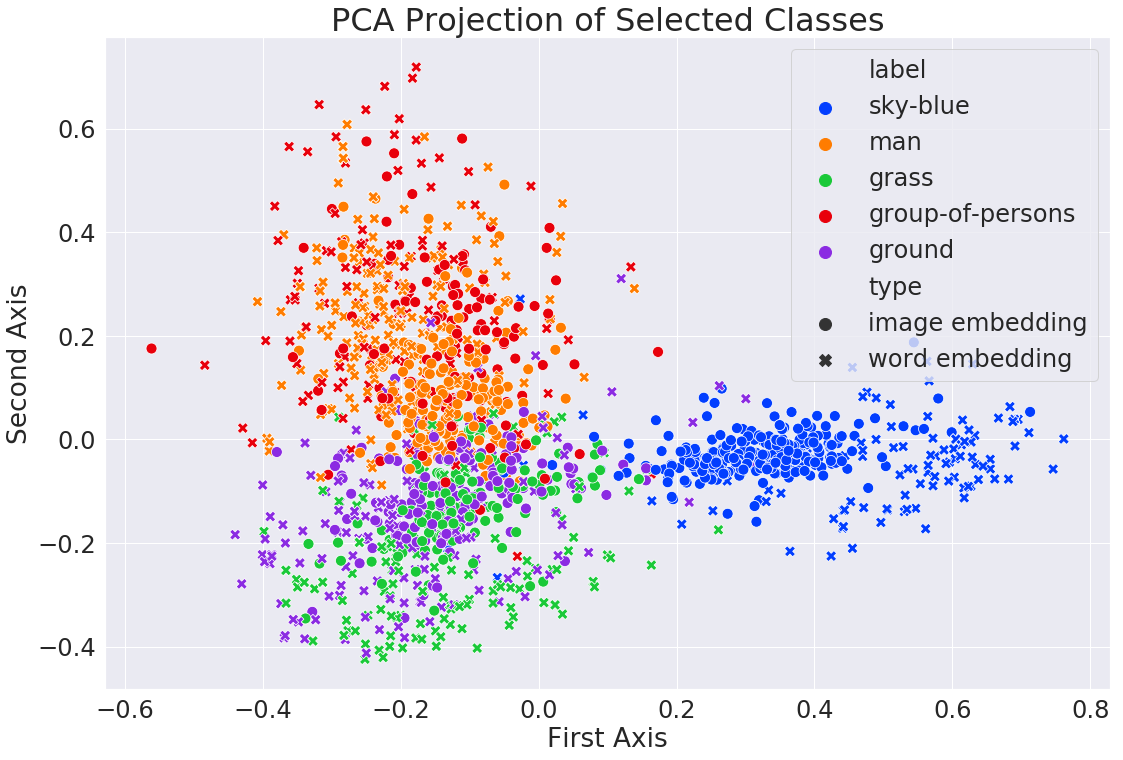

In [21]:
get_poster_graphs_with_final_model(epochs = [18])

Index(['grass', 'ground', 'group-of-persons', 'man', 'sky-blue'], dtype='object', name='label')

common labels size is 5
combined pca explained_variance_ratio_: [0.27940346 0.12887156 0.09331713 0.08192943]

at iter: 38000
avg sim: 0.8432307839393616
std sim: 0.11896400898694992


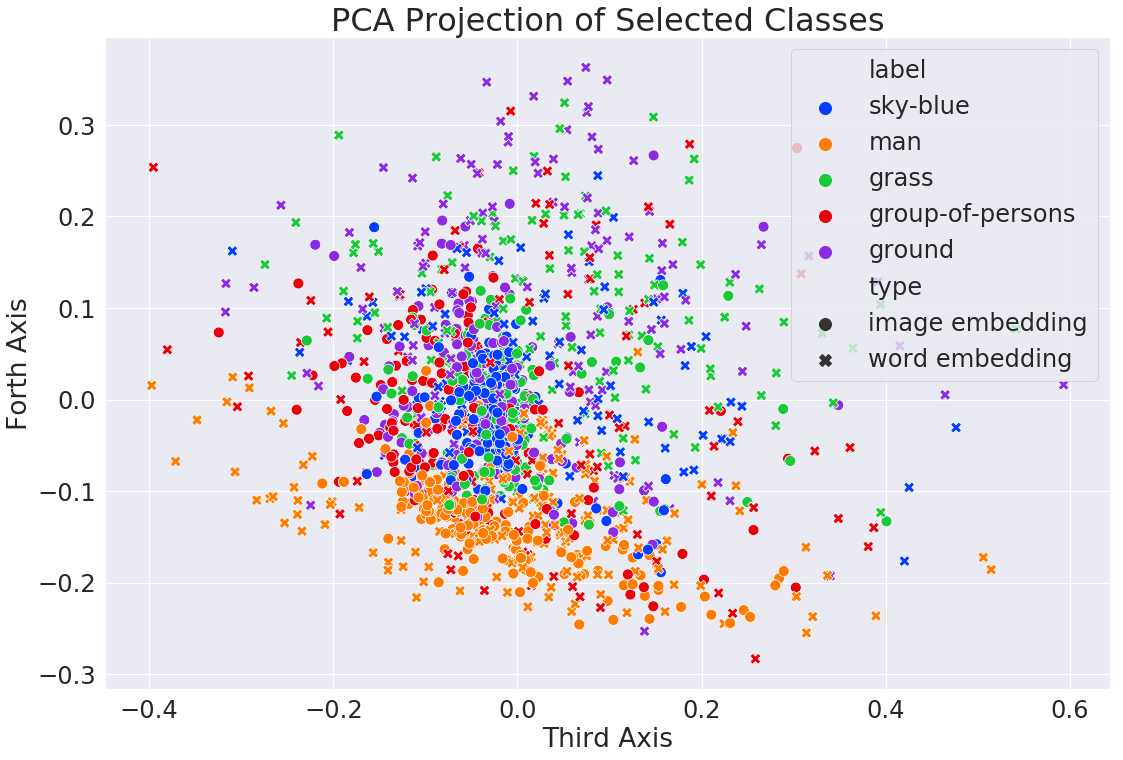

In [22]:
get_poster_graphs_with_final_model_other_two(epochs = [18])

In [ ]:
current_palette = sns.color_palette('bright')
sns.palplot(current_palette)

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
data_path = "../data/"
whole_data = pickle.load(open("whole_data_backup_with_correct_boxes", "rb"))
whole_data.head()

,bbox_id,img,img_size,loc_act_bb,loc_rel_bb,obj_id,expr,emb_expr,label,loc_act_obj,loc_rel_obj,IoU,GIoU
0,20260_f1,20260,"[360, 480]","[0.0, 277.0, 83.0, 336.0]","[0.0, 0.5770833333333333, 0.23055555555555557,...",20260_2,the sky right hand corner,"[-0.009086175, 0.06696806, -0.07156556, 0.0605...",cloud,"[0, 0, 359, 208]","[-1.0, -1.0, 0.9944444444444445, -0.1333333333...",0.000000,-0.338279
1,20260_f1,20260,"[360, 480]","[0.0, 277.0, 83.0, 336.0]","[0.0, 0.5770833333333333, 0.23055555555555557,...",20260_1,water on right,"[-0.010208251, 0.0080347, -0.045048416, 0.0062...",floor-other,"[8, 265, 359, 479]","[-0.9555555555555556, 0.10416666666666674, 0.9...",0.059874,0.043853
2,20260_f1,20260,"[360, 480]","[0.0, 277.0, 83.0, 336.0]","[0.0, 0.5770833333333333, 0.23055555555555557,...",20260_3,middle guy,"[-0.031950668, 0.014514642, 0.006182524, 0.026...",man,"[178, 206, 224, 346]","[-0.011111111111111072, -0.14166666666666672, ...",0.000000,-0.632246
3,20260_f2,20260,"[360, 480]","[0.0, 203.0, 223.0, 341.0]","[0.0, 0.42291666666666666, 0.6194444444444445,...",20260_2,the sky right hand corner,"[-0.009086175, 0.06696806, -0.07156556, 0.0605...",cloud,"[0, 0, 359, 208]","[-1.0, -1.0, 0.9944444444444445, -0.1333333333...",0.012796,-0.134117
4,20260_f2,20260,"[360, 480]","[0.0, 203.0, 223.0, 341.0]","[0.0, 0.42291666666666666, 0.6194444444444445,...",20260_1,water on right,"[-0.010208251, 0.0080347, -0.045048416, 0.0062...",floor-other,"[8, 265, 359, 479]","[-0.9555555555555556, 0.10416666666666674, 0.9...",0.184423,0.088795


In [13]:
valid_imgs = np.loadtxt(data_path + "referit_val_imlist.txt").astype("int")

gt_validation_ids = np.logical_and(np.isin(whole_data["img"].values.astype("int"), valid_imgs),whole_data["IoU"]==1)
gt_val_ids = list(np.argwhere(gt_validation_ids==True))
gt_val_ids = [item for sublist in gt_val_ids for item in sublist]
gt_val_ids = np.array(gt_val_ids)
#gt_val_ids = np.random.choice(gt_val_ids, 1280, replace = False)
print(len(gt_val_ids))
val_data = whole_data.iloc[gt_val_ids]


5842


In [11]:
old_whole_data = pickle.load(open("whole_data", "rb"))
old_whole_data.head()

,bbox_id,img,loc_act,loc_rel,expr,emb_expr,IoU,GIoU
0,20260_f1,20260,"[0.0, 277.0, 83.0, 336.0]","[0.0, 0.5770833333333333, 0.23055555555555557,...",the sky right hand corner,"[-0.009086175, 0.06696806, -0.07156556, 0.0605...",0.000000,-0.338279
1,20260_f1,20260,"[0.0, 277.0, 83.0, 336.0]","[0.0, 0.5770833333333333, 0.23055555555555557,...",water on right,"[-0.010208251, 0.0080347, -0.045048416, 0.0062...",0.059874,0.043853
2,20260_f1,20260,"[0.0, 277.0, 83.0, 336.0]","[0.0, 0.5770833333333333, 0.23055555555555557,...",middle guy,"[-0.031950668, 0.014514642, 0.006182524, 0.026...",0.000000,-0.632246
3,20260_f2,20260,"[0.0, 203.0, 223.0, 341.0]","[0.0, 0.42291666666666666, 0.6194444444444445,...",the sky right hand corner,"[-0.009086175, 0.06696806, -0.07156556, 0.0605...",0.012796,-0.134117
4,20260_f2,20260,"[0.0, 203.0, 223.0, 341.0]","[0.0, 0.42291666666666666, 0.6194444444444445,...",water on right,"[-0.010208251, 0.0080347, -0.045048416, 0.0062...",0.184423,0.088795


In [12]:
import model_v3dot3 as modelClass

In [10]:
batch_size = 32
gt_val_dataset = modelClass.LocalizationDataset(data_pickle=old_whole_data.iloc[gt_val_ids],
                                   data_path=data_path,
                                   transform=transforms.Compose([
                                       # Assuming image size 480x480, bbox size 240x240
                                               modelClass.Rescale((240,240), (240,240)),
                                               modelClass.ToTensor()
                                           ]))
gt_val_loader = torch.utils.data.DataLoader(gt_val_dataset,  batch_size = batch_size, shuffle = False, num_workers=4)

In [ ]:
model = modelClass.myModel()
device = 'cuda'
model.to(device)

word_embs_list = []
img_embs_list = []

for i in range(6):
    print(str(i) + ' started')
    path ='models/model_v4.1_unfrozen_'+str(i)+'.pt'
    checkpoint = torch.load(path)
    start_epoch = checkpoint['epoch'] + 1
    model.load_state_dict(checkpoint['model_state_dict'])
    word_embs = []
    img_embs = []
    with torch.set_grad_enabled(False):
        for sample in gt_val_loader:
            image, bbox_image, loc_rel, embedding, IoU = modelClass.get_torch_data(sample)
            output = model(image,bbox_image,loc_rel,embedding)
            img_emb, word_emb = torch.split(output, 512, dim=1)
            img_emb, word_emb = img_emb.cpu().numpy(), word_emb.cpu().numpy()
            word_embs = word_embs + list(word_emb)
            img_embs = img_embs + list(img_emb)
    word_embs_list.append(word_embs)
    img_embs_list.append(img_embs)

with open('word_embs_list_v4.1.pkl', 'wb') as f:
    pickle.dump(word_embs_list, f)

with open('img_embs_list_v4.1.pkl', 'wb') as f:
    pickle.dump(img_embs_list, f)

print('finished')

In [11]:
#FULL DATA MODEL

abbrv = 'full_3.3'
model = modelClass.myModel()
device = 'cuda'
model.to(device)

word_embs_list = []
img_embs_list = []

load = False
if load:
    word_embs_list = pickle.load(open('word_embs_'+abbrv+'.pkl', 'rb'))
    img_embs_list = pickle.load(open('img_embs_'+abbrv+'.pkl', 'rb'))

for i in range(0,19):
    print(str(i) + ' started')
    path ='models/model_v3.3_full_data_iter'+str((i+1)*2000)+'.pt'
    checkpoint = torch.load(path)
    start_epoch = checkpoint['epoch'] + 1
    model.load_state_dict(checkpoint['model_state_dict'])
    word_embs = []
    img_embs = []
    with torch.set_grad_enabled(False):
        for sample in gt_val_loader:
            image, bbox_image, loc_rel, embedding, _ = modelClass.get_torch_data(sample)
            output = model(image,bbox_image,loc_rel,embedding)
            img_emb, word_emb = torch.split(output, 512, dim=1)
            img_emb, word_emb = img_emb.cpu().numpy(), word_emb.cpu().numpy()
            word_embs = word_embs + list(word_emb)
            img_embs = img_embs + list(img_emb)
    word_embs_list.append(word_embs)
    img_embs_list.append(img_embs)

with open('word_embs_'+abbrv+'.pkl', 'wb') as f:
    pickle.dump(word_embs_list, f)

with open('img_embs_'+abbrv+'.pkl', 'wb') as f:
    pickle.dump(img_embs_list, f)

print('finished')

0 started
1 started
2 started
3 started
4 started
5 started
6 started
7 started
8 started
9 started
10 started
11 started
12 started
13 started
14 started
15 started
16 started
17 started
18 started
finished


In [14]:
#FULL DATA  LAST

abbrv = 'full_3.3'
model = modelClass.myModel()
device = 'cuda'
model.to(device)

word_embs_list = []
img_embs_list = []

load = False
if load:
    word_embs_list = pickle.load(open('word_embs_'+abbrv+'.pkl', 'rb'))
    img_embs_list = pickle.load(open('img_embs_'+abbrv+'.pkl', 'rb'))

for i in range(42,43):
    print(str(i) + ' started')
    path ='models/model_v3.3_full_data_iter'+str((i+1)*2000)+'.pt'
    checkpoint = torch.load(path)
    start_epoch = checkpoint['epoch'] + 1
    model.load_state_dict(checkpoint['model_state_dict'])
    word_embs = []
    img_embs = []
    with torch.set_grad_enabled(False):
        for sample in gt_val_loader:
            image, bbox_image, loc_rel, embedding, _ = modelClass.get_torch_data(sample)
            output = model(image,bbox_image,loc_rel,embedding)
            img_emb, word_emb = torch.split(output, 512, dim=1)
            img_emb, word_emb = img_emb.cpu().numpy(), word_emb.cpu().numpy()
            word_embs = word_embs + list(word_emb)
            img_embs = img_embs + list(img_emb)
    word_embs_list.append(word_embs)
    img_embs_list.append(img_embs)
'''
with open('word_embs_'+abbrv+'.pkl', 'wb') as f:
    pickle.dump(word_embs_list, f)

with open('img_embs_'+abbrv+'.pkl', 'wb') as f:
    pickle.dump(img_embs_list, f)
'''

print('finished')

42 started
finished


In [15]:
# load embeddings for gt validation data
abbrv = 'full_3.3'
word_embs_list = pickle.load(open('word_embs_'+abbrv+'.pkl', 'rb'))
img_embs_list = pickle.load(open('img_embs_'+abbrv+'.pkl', 'rb'))

In [6]:
len(word_embs_list)

19

In [13]:
list(range(42,43))

[42]

In [36]:
list(range(4,30,5))

[4, 9, 14, 19, 24, 29]


common labels size is 5

at epoch: 5
combined pca explained_variance_ratio_: [0.28541142 0.13530107]
text pca explained_variance_ratio_: 	[0.34236735 0.1288714 ]
image pca explained_variance_ratio_: 	[0.26572454 0.21233853]


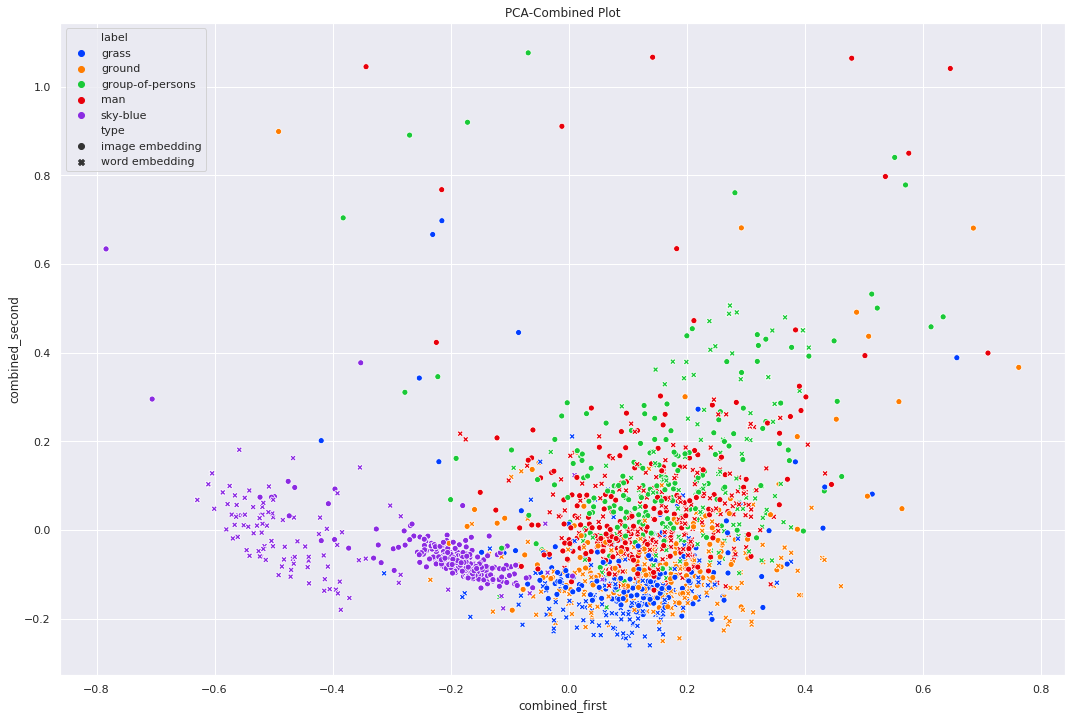


at epoch: 10
combined pca explained_variance_ratio_: [0.2627879  0.13240451]
text pca explained_variance_ratio_: 	[0.31044615 0.14491861]
image pca explained_variance_ratio_: 	[0.24762544 0.19567843]


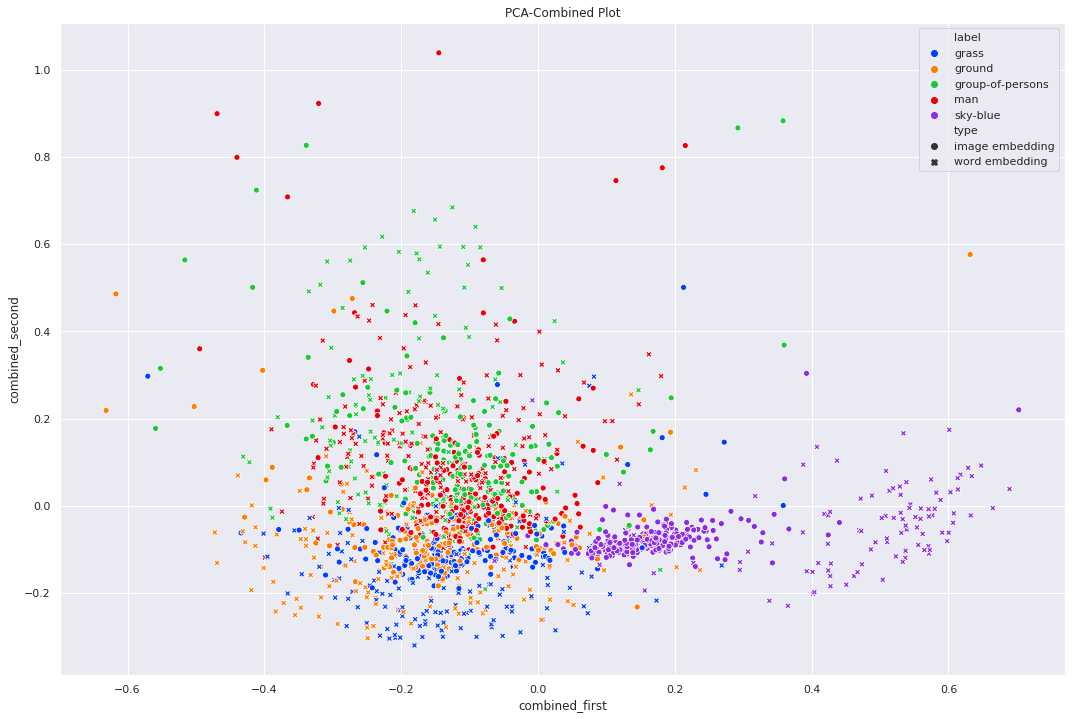


at epoch: 15
combined pca explained_variance_ratio_: [0.29339877 0.11948388]
text pca explained_variance_ratio_: 	[0.30394587 0.13740008]
image pca explained_variance_ratio_: 	[0.30196809 0.13156762]


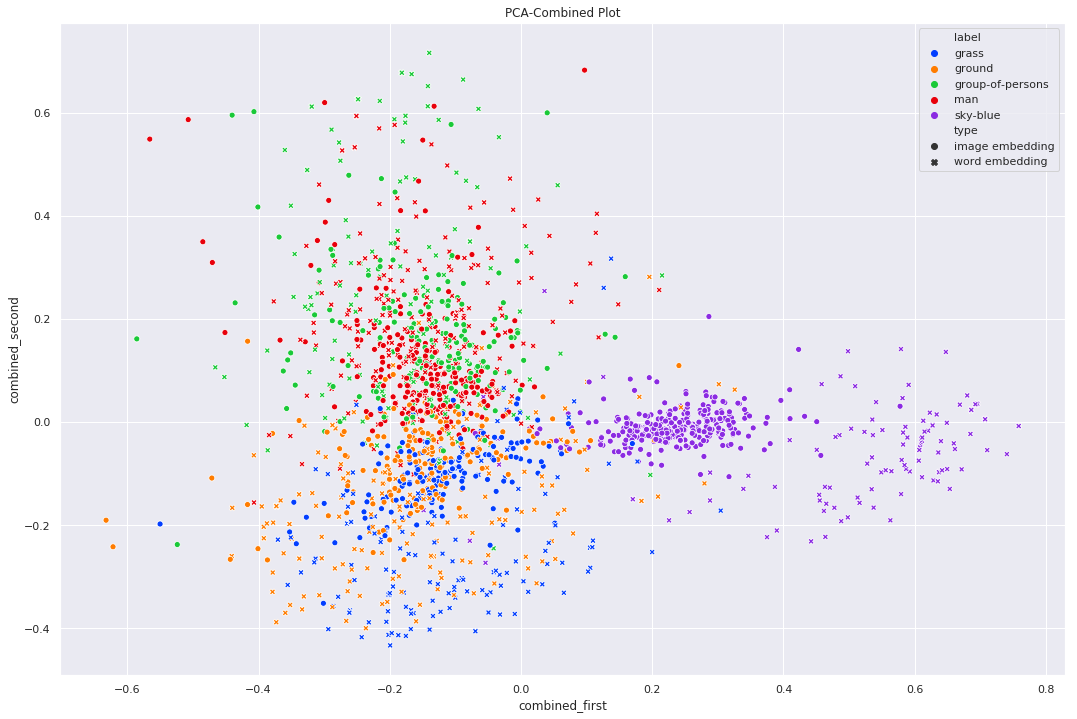

KeyboardInterrupt: 

In [48]:
get_graphs(min_instance_count = 180, sim_filter=False, epochs = range(4,30,5), figsize = (18,12), only_combined = True)

Index(['grass', 'ground', 'group-of-persons', 'man', 'sky-blue'], dtype='object', name='label')

common labels size is 5
combined pca explained_variance_ratio_: [0.27940346 0.12887156 0.09331713]

at iter: 38000
avg sim: 0.8432307839393616
std sim: 0.11896400898694992


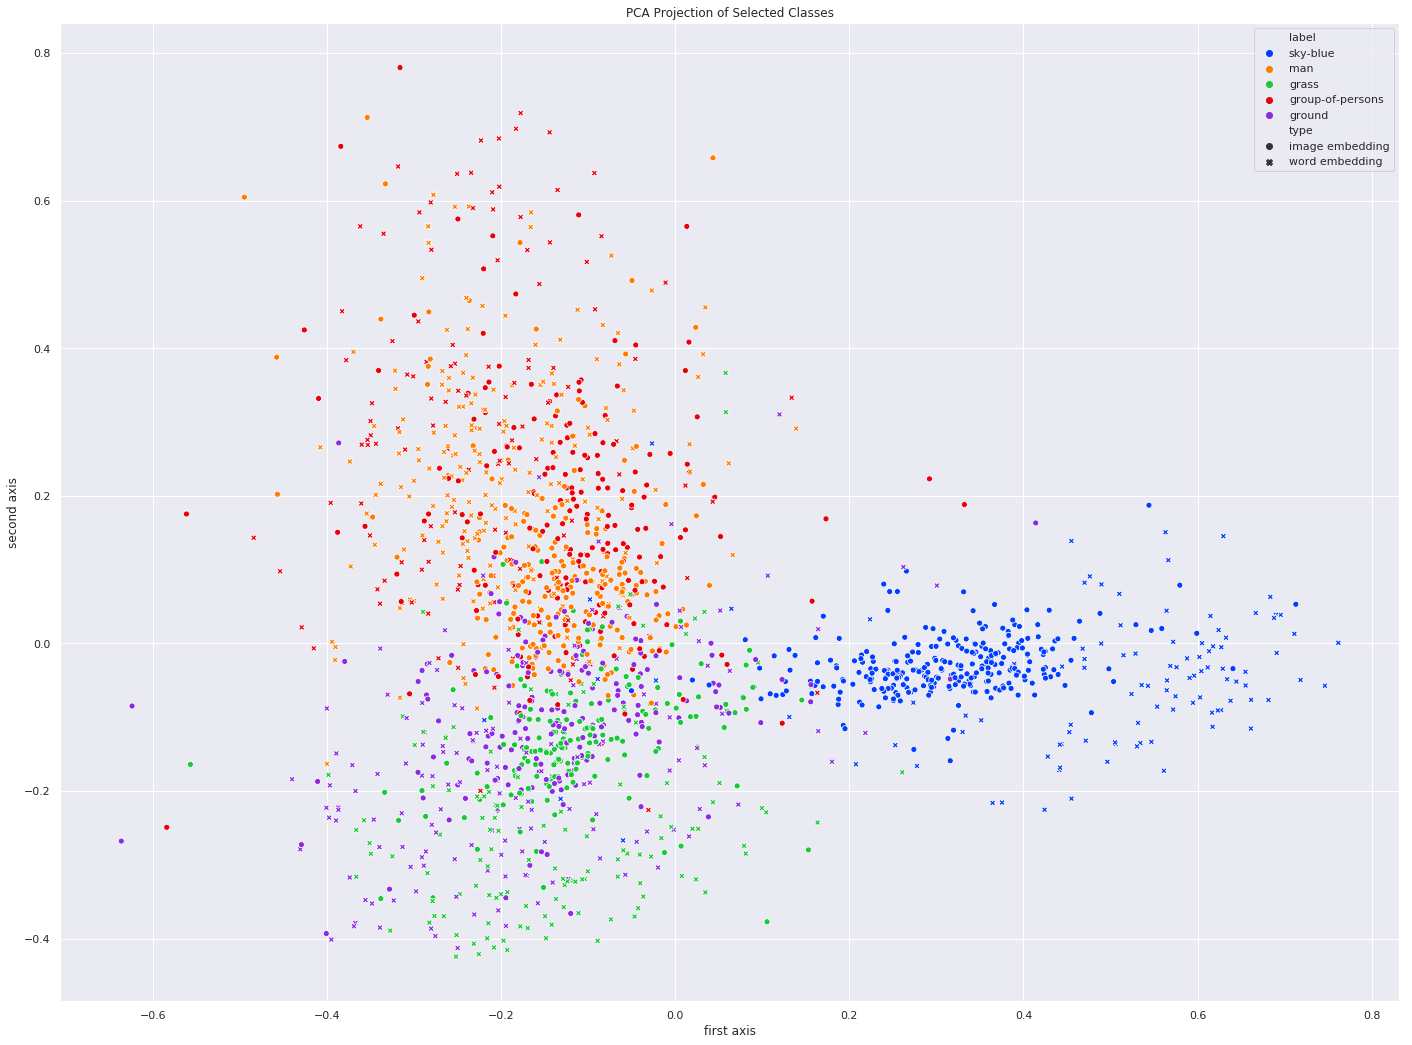

In [19]:
get_graphs_with_final_model(min_instance_count = 170, sim_filter=False, epochs = [18], figsize = (24,18))

In [26]:
#get_graphs(min_instance_count = 180, sim_filter=False, sim_thres=-1, epochs = range(6), figsize = (18,12))

In [196]:
model = modelClass.myModel()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
device = 'cuda'
model.to(device)
train_loss = []
val_loss = []

In [197]:
start_epoch = checkpoint['epoch'] + 1
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.load_state_dict(checkpoint['model_state_dict'])
train_loss = checkpoint['train_loss']
val_loss = checkpoint['validation_loss']

In [13]:
word_embs = []
img_embs = []
with torch.set_grad_enabled(False):
    for sample in gt_val_loader:
        image, bbox_image, loc_rel, embedding, IoU = modelClass.get_torch_data(sample)
        output = model(image,bbox_image,loc_rel,embedding)
        img_emb, word_emb = torch.split(output, 512, dim=1)
        img_emb, word_emb = img_emb.cpu().numpy(), word_emb.cpu().numpy()
        word_embs = word_embs + list(word_emb)
        img_embs = img_embs + list(img_emb)